In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Fault import GridFault, Fault
from Prior import LatLonPrior
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

In [2]:
%matplotlib notebook

In [3]:
def split_rect(fault,lat,lon,length,width,deltadepth,n=11,m=3):
    R = fault.R
    # n = int(length/15000)
    # m = int(width/15000)
    n_steps = 8
    length_step = length/(n*n_steps)
    width_step = width/(m*n_steps)
    sublength = length/n
    subwidth = width/m

    lats = np.empty(n)
    lons = np.empty(n)
    lats[(n - 1)//2] = lat
    lons[(n - 1)//2] = lon

    # add strikeward and anti-strikeward centers
    bearing1 = fault.strike_from_lat_lon(lat,lon)
    bearing2 = (bearing1-180)%360
    lat1,lon1 = lat,lon
    lat2,lon2 = lat,lon
    for i in range(1,(n - 1)//2+1):
        for j in range(n_steps):
            lat1,lon1 = Fault.step(lat1,lon1,bearing1,length_step,R)
            lat2,lon2 = Fault.step(lat2,lon2,bearing2,length_step,R)
            bearing1 = fault.strike_from_lat_lon(lat1, lon1)
            bearing2 = (fault.strike_from_lat_lon(lat2, lon2)-180)%360
        lats[(n-1)//2+i] = lat1
        lats[(n-1)//2-i] = lat2
        lons[(n-1)//2+i] = lon1
        lons[(n-1)//2-i] = lon2

    strikes = fault.strike_map(np.vstack((lats,lons)).T)
    dips = fault.dip_map(np.vstack((lats,lons)).T)
    dipward = (strikes+90)%360

    Lats = np.empty((m,n))
    Lons = np.empty((m,n))
    Strikes = np.empty((m,n))
    Dips = np.empty((m,n))
    Lats[(m-1)//2] = lats
    Lons[(m-1)//2] = lons
    Strikes[(m-1)//2] = strikes
    Dips[(m-1)//2] = dips

    # add dipward and antidipward centers
    templats1,templons1 = lats.copy(),lons.copy()
    templats2,templons2 = lats.copy(),lons.copy()
    tempdips1,tempdips2 = dips.copy(),dips.copy()
    for i in range(1,(m - 1)//2+1):
        for j in range(n_steps):
            templats1,templons1 = Fault.step(templats1,templons1,dipward,width_step*np.cos(np.deg2rad(tempdips1)),R)
            templats2,templons2 = Fault.step(templats2,templons2,dipward,-width_step*np.cos(np.deg2rad(tempdips2)),R)
            tempdips1 = fault.dip_map(np.vstack((templats1,templons1)).T)
            tempdips2 = fault.dip_map(np.vstack((templats2,templons2)).T)
        Lats[(m-1)//2+i] = templats1
        Lats[(m-1)//2-i] = templats2
        Lons[(m-1)//2+i] = templons1
        Lons[(m-1)//2-i] = templons2
        Strikes[(m-1)//2+i] = fault.strike_map(np.vstack((templats1,templons1)).T)
        Strikes[(m-1)//2-i] = fault.strike_map(np.vstack((templats2,templons2)).T)
        Dips[(m-1)//2+i] = tempdips1
        Dips[(m-1)//2-i] = tempdips2

    Depths = fault.depth_map(np.vstack((Lats.flatten(),Lons.flatten())).T) + deltadepth
    data = [Lats,Lons,Strikes,Dips,Depths]
    data = [arr.flatten() for arr in data]
    return np.array(data).T, sublength, subwidth

In [4]:
def corners(lat,lon,strike,length,width,R):
    """Computes the lat-lon coordinates of the rectangle corners"""
    edge1 = Fault.step(lat,lon,strike,length/2,6377905)
    edge2 = Fault.step(lat,lon,strike-180,length/2,R)
    corner1 = Fault.step(edge1[0],edge1[1],strike+90,width/2,R)
    corner2 = Fault.step(edge1[0],edge1[1],strike-90,width/2,R)
    corner3 = Fault.step(edge2[0],edge2[1],strike+90,width/2,R)
    corner4 = Fault.step(edge2[0],edge2[1],strike-90,width/2,R)
    return np.vstack((corner1,corner2,corner3,corner4))

def edges(lat,lon,strike,length,width,dip,R):
    width = np.cos(np.deg2rad(dip))*width
    centerline = Fault.step(lat,lon,strike,np.linspace(-length/2,length/2),R)
    dipward = Fault.step(centerline[0],centerline[1],strike+90,width/2,R)
    antidipward = Fault.step(centerline[0],centerline[1],strike-90,width/2,R)
    strikeward = Fault.step(centerline[0][0],centerline[1][0],strike-90,np.linspace(-width/2,width/2),R)
    antistrikeward = Fault.step(centerline[0][-1],centerline[1][-1],strike+90,np.linspace(-width/2,width/2),R)
    lats = np.hstack((dipward[0],strikeward[0],antidipward[0][::-1],antistrikeward[0]))
    lons = np.hstack((dipward[1],strikeward[1],antidipward[1][::-1],antistrikeward[1]))
    return lats,lons

In [5]:
data = np.load("bandadata.npz")
R = 6377905
fault = GridFault(data['lat'],data['lon'],data['depth'],data['depth_unc'],data['dip'],data['strike'],R = 6377905,name='Sumatra')

In [6]:
depth_mu = 30000
depth_std = 10000
mindepth = 1000
maxdepth = 50000
minlon = 126
latlon = LatLonPrior(fault,depth_mu,depth_std,mindepth,maxdepth,minlon)

TypeError: __init__() takes 6 positional arguments but 7 were given

221.797058105 10.4870653152


<IPython.core.display.Javascript object>


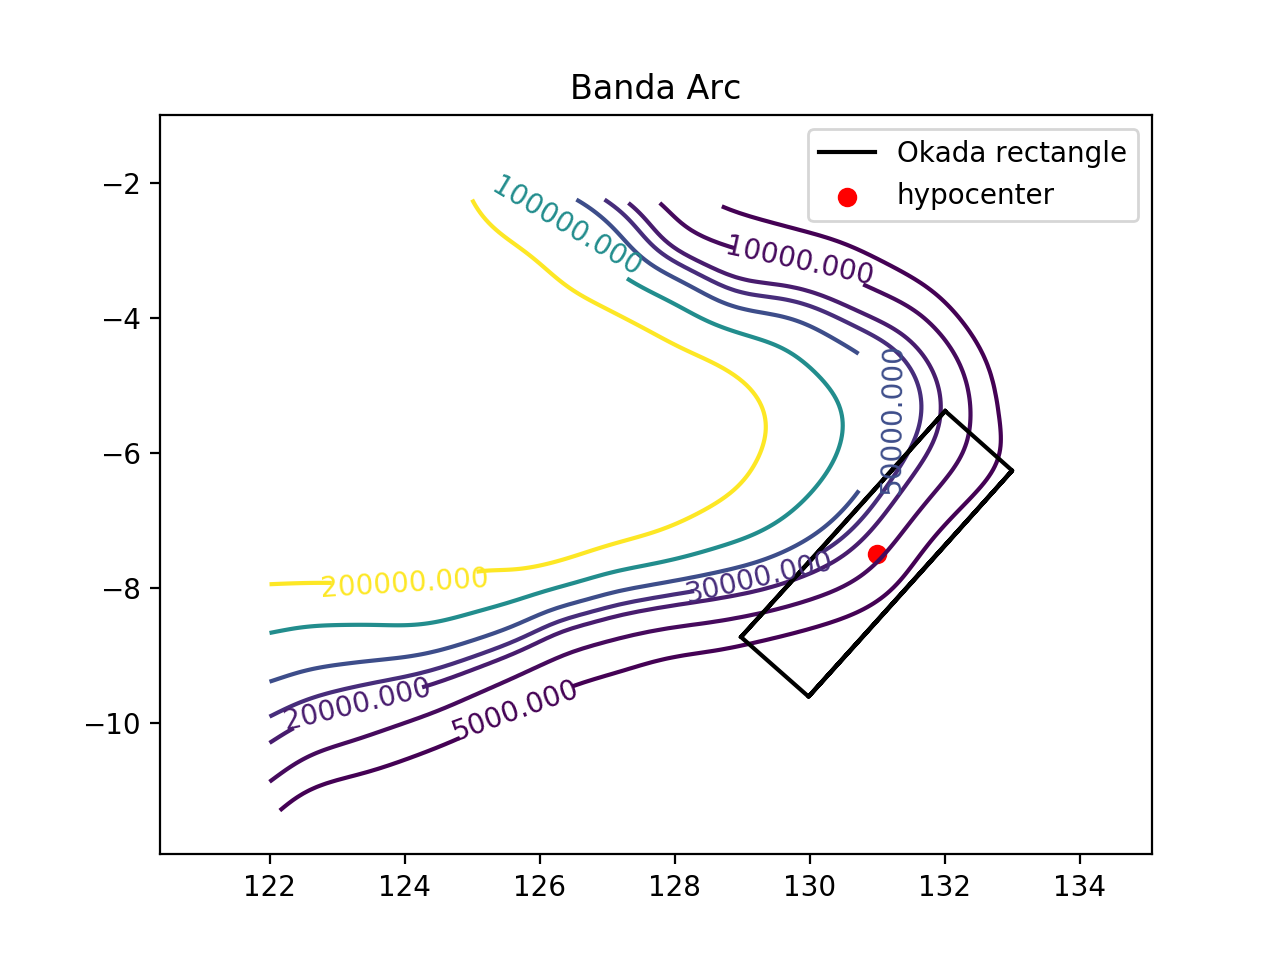

In [8]:
Lat,Lon = np.meshgrid(fault.lat,fault.lon,indexing='ij')
lat,lon = -7.5,131
strike = fault.strike_from_lat_lon(lat,lon)
dip = fault.dip_from_lat_lon(lat,lon)
print(strike,dip)
length,width = 500000,150000
lats,lons = edges(lat,lon,strike,length,width,dip,R)
fig = plt.figure()
plt.axis("equal")
plt.scatter(lon,lat,c='r',label="hypocenter")
plt.plot(lons,lats,c='k',label="Okada rectangle")
levels = [5000,10000,20000,30000,50000,100000,200000]
CS = plt.contour(Lon,Lat,fault.depth,levels=levels)
plt.clabel(CS)
plt.title("Banda Arc")
plt.legend()
plt.show()

(30255.777359, 35280.220031699995)


<IPython.core.display.Javascript object>


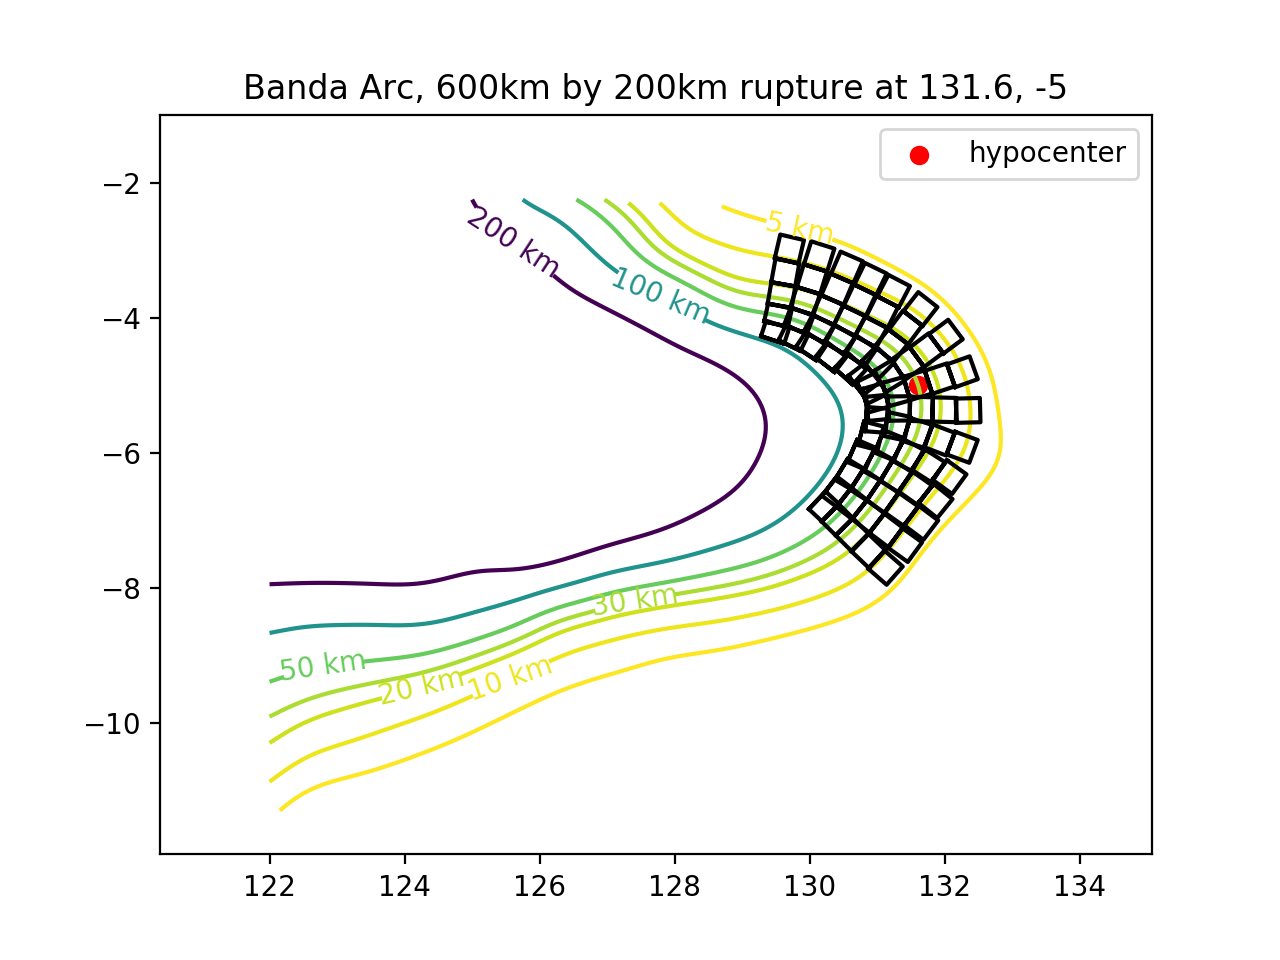

In [13]:
lat,lon = -5,131.6
length,width = 600000,200000
print(fault.depth_from_lat_lon(lat,lon))

lats = []
lons = []
try:
    rects,sublength,subwidth = split_rect(fault,lat,lon,length,width,0,n=15,m=5)
except ValueError:
    print('rejected!')
    
for rect in rects:
    ret = edges(rect[0],rect[1],rect[2],sublength,subwidth,rect[3],R)
    lats.append(ret[0])
    lons.append(ret[1])

fig = plt.figure()
plt.axis("equal")
levels = [5000,10000,20000,30000,50000,100000,200000]
CS = plt.contour(Lon,Lat,fault.depth,levels=levels,cmap='viridis_r')
plt.clabel(CS,fmt=lambda d: f"{d/1000:1.0f} km")
# plt.pcolormesh(Lon,Lat,fault.depth,alpha=.2)
# plt.colorbar()

# plt.scatter(rects[:,1],rects[:,0],s=4,c='k')
plt.scatter(lon,lat,c='r',label="hypocenter")
for i in range(len(rects)):
    plt.plot(lons[i],lats[i],c='k')
plt.title(f"Banda Arc, 600km by 200km rupture at {lon}, {lat}")
plt.legend()
plt.show()

# print(latlon.logpdf(lat,lon,rects,subwidth,0))

In [21]:
lat

-4.75

In [8]:
def split_rect3(fault,lat,lon,length,width,R,n=11,m=3):
#     n = int(length/15000)
#     m = int(width/15000)
    n_steps = 8
    length_step = length/(n*n_steps)
    width_step = width/(m*n_steps)
    sublength = length/n
    subwidth = width/m
    
    lats = np.empty(n)
    lons = np.empty(n)
    lats[(n - 1)//2] = lat
    lons[(n - 1)//2] = lon
    
    # add strikeward and anti-strikeward centers
    bearing1 = fault.strike_from_lat_lon(lat,lon)
    bearing2 = (bearing1-180)%360
    lat1,lon1 = lat,lon
    lat2,lon2 = lat,lon
    for i in range(1,(n - 1)//2+1):
        for j in range(n_steps):
            lat1,lon1 = Fault.step(lat1,lon1,bearing1,length_step,R)
            lat2,lon2 = Fault.step(lat2,lon2,bearing2,length_step,R)
            bearing1 = fault.strike_from_lat_lon(lat1, lon1)
            bearing2 = (fault.strike_from_lat_lon(lat2, lon2)-180)%360
        lats[(n-1)//2+i] = lat1
        lats[(n-1)//2-i] = lat2
        lons[(n-1)//2+i] = lon1
        lons[(n-1)//2-i] = lon2

    strikes = fault.strike_map(np.vstack((lats,lons)).T)
    dips = fault.dip_map(np.vstack((lats,lons)).T)
    dipward = (strikes+90)%360
    
    Lats = np.empty((m,n))
    Lons = np.empty((m,n))
    Strikes = np.empty((m,n))
    Dips = np.empty((m,n))
    Lats[(m-1)//2] = lats
    Lons[(m-1)//2] = lons
    Strikes[(m-1)//2] = strikes
    Dips[(m-1)//2] = dips
    
    # add dipward and antidipward centers
    templats1,templons1 = lats.copy(),lons.copy()
    templats2,templons2 = lats.copy(),lons.copy()
    tempdips1,tempdips2 = dips.copy(),dips.copy()
    for i in range(1,(m - 1)//2+1):
        for j in range(n_steps):
            templats1,templons1 = Fault.step(templats1,templons1,dipward,width_step*np.cos(np.deg2rad(tempdips1)),R)
            templats2,templons2 = Fault.step(templats2,templons2,dipward,-width_step*np.cos(np.deg2rad(tempdips2)),R)
            tempdips1 = fault.dip_map(np.vstack((templats1,templons1)).T)
            tempdips2 = fault.dip_map(np.vstack((templats2,templons2)).T)
        Lats[(m-1)//2+i] = templats1
        Lats[(m-1)//2-i] = templats2
        Lons[(m-1)//2+i] = templons1
        Lons[(m-1)//2-i] = templons2
        Strikes[(m-1)//2+i] = fault.strike_map(np.vstack((templats1,templons1)).T)
        Strikes[(m-1)//2-i] = fault.strike_map(np.vstack((templats2,templons2)).T)
        Dips[(m-1)//2+i] = tempdips1
        Dips[(m-1)//2-i] = tempdips2

    Depths = fault.depth_map(np.vstack((Lats.flatten(),Lons.flatten())).T)
    data = [Lats,Lons,Strikes,Dips,Depths]
    data = [arr.flatten() for arr in data]
    return np.array(data).T, sublength, subwidth

<IPython.core.display.Javascript object>


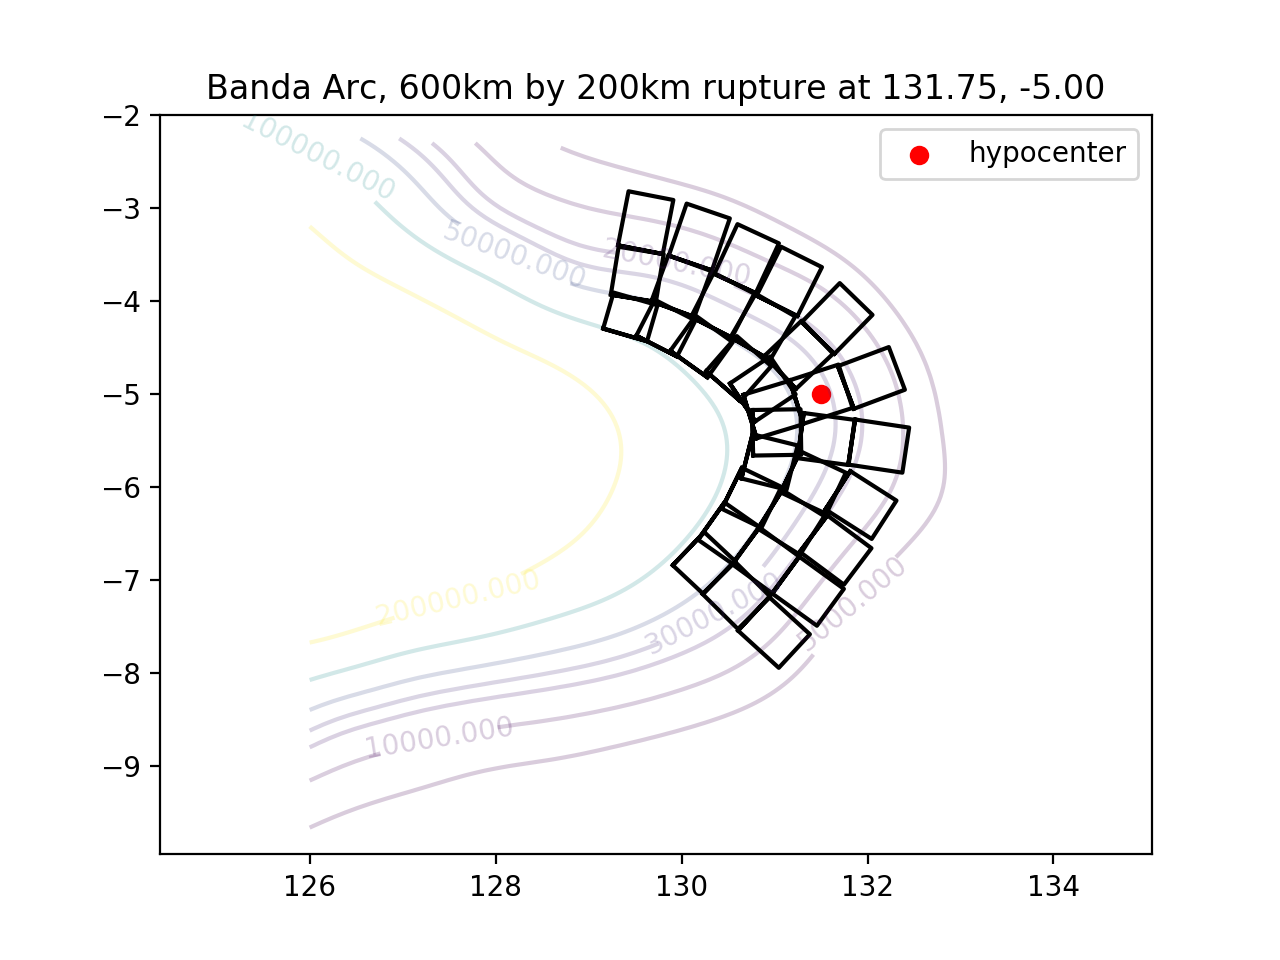

In [9]:
lat,lon = -5,131.5
length,width = 600000,200000

lats = []
lons = []

rects,sublength,subwidth = split_rect(fault,lat,lon,length,width,R)
for rect in rects:
    ret = edges(rect[0],rect[1],rect[2],sublength,subwidth,rect[3],R)
    lats.append(ret[0])
    lons.append(ret[1])

fig = plt.figure()
plt.axis("equal")
levels = [5000,10000,20000,30000,50000,100000,200000]
CS = plt.contour(Lon,Lat,fault.depth,levels=levels,alpha=.2)
plt.clabel(CS)
plt.scatter(lon,lat,c='r',label="hypocenter")
for i in range(len(rects)):
    plt.plot(lons[i],lats[i],c='k')
plt.title("Banda Arc, 600km by 200km rupture at 131.75, -5.00")
plt.legend()
plt.show()